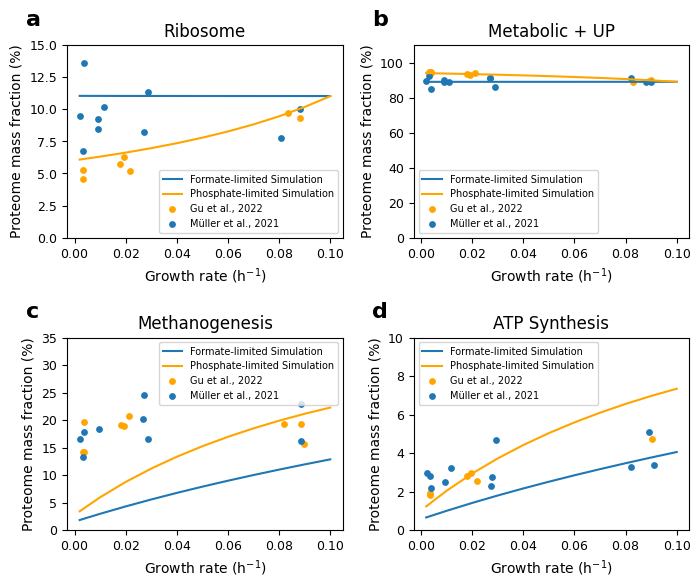

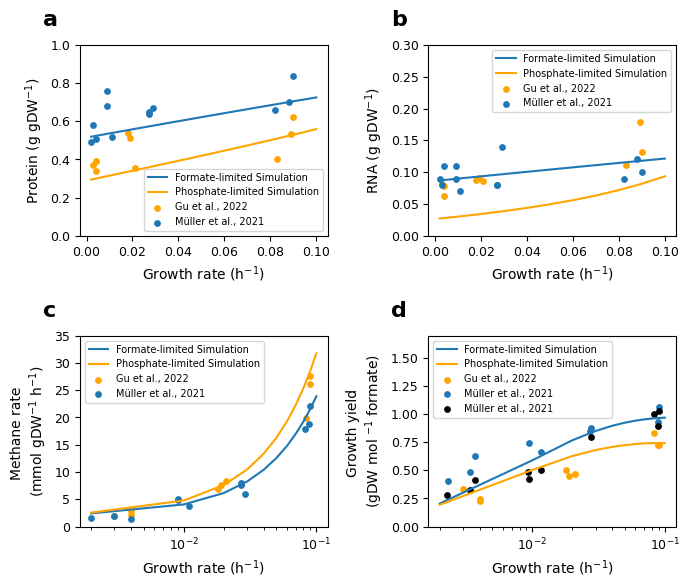

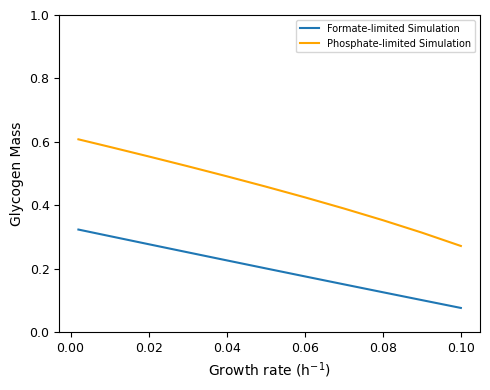

In [1]:
from simulation import Simulation
from extract_fluxes import Fluxes
import matplotlib.pyplot as plt
import  numpy as np
import pandas as pd
def limitation_simulation(limitation_type):
    total_protein_mass=0.6
    up_phosphate_ratio=0.44*total_protein_mass
    up_formate_ratio=0.75*total_protein_mass
    methane_id,formate_id = "R944","R895"
    # closed import H2 ,CO2 , CO ,Aceteta
    closed_reactions = ["R946", "R913", "R1165", "R983"]
    sim = Simulation()
     # objective is phosphate
    if limitation_type == "phosphate":
        sim.set_parameter(model_file='pcMMP.xml', objective="R871", GAM=70, NGAM=1, excel_file='pcMMP.xlsx')
        sim.set_constraint = [f"UP >={up_phosphate_ratio}"]
    # objective is formate 
    elif limitation_type == "formate":
        sim.set_parameter(model_file='pcMMP.xml', objective="R895", GAM=25, NGAM=1, excel_file='pcMMP.xlsx')
        sim.set_constraint = [f"UP >= {up_formate_ratio}"]
    sim.close_reactions(closed_reactions)
    results = {
        "mu_list": [], "methane_list": [], "formate_list": [], "rna_list": [],
         "glycogen_list": [], "metabolic_up_list": [], "methanogenesis_list": [],
        "ribosome_list": [], "total_proteins": [], "atp_list": []
    }
    mus=[0.002, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09,0.1]
    for i, mu in enumerate(mus, start=1):
        if limitation_type == "phosphate":
            y = -183.67*mu + 40.367
            sim.kcat_ribo = y

        sim.file_path = f"output/lp_file_limited_{i}.lp"
        sim.output_file = f"output/output_limited_{i}.lp"
        if sim.check_mu_optimal(mu):
            fluxes = Fluxes(sim.model, f'output/output_limited_{i}.lp')
            results["mu_list"].append(mu)
            results["methane_list"].append(fluxes.extract_reaction_flux(methane_id))
            results["formate_list"].append(fluxes.extract_reaction_flux(formate_id))
            results["rna_list"].append(fluxes.extract_reaction_flux("RNA"))
            results["glycogen_list"].append(fluxes.extract_reaction_flux("Glycogen"))
            total_protein = fluxes.extract_reaction_flux("total_protein")
            up = fluxes.extract_reaction_flux("UP")
            results["metabolic_up_list"].append(((up + fluxes.extract_reaction_flux("metaboicMass")) / total_protein)*100)
            results["methanogenesis_list"].append((fluxes.extract_reaction_flux("Methanogenesis_mass") / total_protein)*100)
            results["ribosome_list"].append((fluxes.extract_reaction_flux("ribosome_mass") / total_protein)*100)
            results["total_proteins"].append(total_protein)
            results["atp_list"].append((fluxes.extract_reaction_flux("ATP_Synthase") / total_protein)*100)
            
        else:
            print(f"mu={mu} is not optimal")

    return results


def calculate_growth_yield(mu_list, formate_list):
    growth_yield=[]
    for i in range(len(formate_list)):
        value = (mu_list[i]/formate_list[i])*1000
        growth_yield.append(value)
    return growth_yield
    

def plot_comparison_figures(results_phosphate, results_formate):
    plt.rcParams.update({
    "axes.titlesize": 12,
    "axes.labelsize": 10,
    "xtick.labelsize":9,
    "ytick.labelsize": 9,
    "legend.fontsize": 7
})
    
    # Figure 1: plot Metabolic + UP , Ribosome , Methanogenesis and Atp synthesis
    fig1, axes1 = plt.subplots(2, 2, figsize=(7, 6))
    # exp_data_figure_1 : experiment data from Müller et al., 2021 and Gu et al., 2022
    exp_data_fig_1 = {
   
    "ribosome": {
        "formate_x": [0.003378591, 0.002283602, 0.003677198, 0.009335012, 0.009236709, 0.011536363, 0.080918156, 0.088069874, 0.027194596, 0.028672867],
        "formate_y": [6.737044289, 9.443378583, 13.58925051, 8.493282875, 9.241842863, 10.16314822, 7.773513233, 10.0191943, 8.205375018, 11.31477965],
        "phosphate_x": [0.003272973, 0.003487615, 0.021544347, 0.017806336, 0.019380114, 0.083529305, 0.088069874],
        "phosphate_y": [4.577735363, 5.268714659, 5.153551077, 5.758158235, 6.305182504, 9.73128644, 9.328215001]
    }, "metabolic_up": {
        "formate_x": [0.003,0.002,0.004,0.009,0.009,0.011,0.027,0.027,0.029,0.090,0.082,0.088],
        "formate_y":[92.53326444,89.68149127,84.6638401,89.73814579,88.94636537,88.69243964,90.8952381,91.36403345,86.06815203,88.63525391,91.35786802,88.60987625],
        
        "phosphate_x": [0.004,0.003,0.004,0.019,0.018,0.021,0.089,0.083,0.090],
         
        "phosphate_y":[94.72140762,94.69831643,94.10985305,92.98337479,93.54020768,94.2591956,89.57755165,89.03666427,89.80582524]

        
    },
    "methanogenesis": {
        "formate_x": [0.003398735, 0.002305956, 0.00375417, 0.009373944, 0.028557722, 0.026903308, 0.02717223, 0.088749165, 0.088749165],
        "formate_y": [13.20652367, 16.57608937, 17.88043598, 18.42391425, 16.63043637, 20.16304514, 24.61956739, 16.1413051, 22.9347835],
        "phosphate_x": [0.003536682, 0.003266172, 0.00350168, 0.01937568, 0.018072553, 0.021401958, 0.088749165, 0.081960935, 0.089636288],
        "phosphate_y": [14.18478415, 14.18478415, 19.56521987, 18.91304553, 19.18478466, 20.70652341, 19.23913166, 19.29348073, 15.70652289]
    },
    "atp_synthesis": {
        "formate_x": [0.002303648, 0.003407521, 0.003738584, 0.009352273, 0.011611202, 0.027304966, 0.027873429, 0.029346868, 0.089285937, 0.091144783, 0.082222198],
        "formate_y": [2.940297462, 2.791043731, 2.164179089, 2.477612264, 3.208955201, 2.268655675, 2.746268865, 4.701492504, 5.104477689, 3.402984937, 3.253731206],
        "phosphate_x": [0.003550878, 0.003303814, 0.021767461, 0.01789767, 0.019435281, 0.090210537],
        "phosphate_y": [1.835821338, 1.925373348, 2.552239129, 2.791043731, 2.97014946, 4.746268509]
    }
}
    titles_fig1 = [ "Ribosome","Metabolic + UP", "Methanogenesis", "ATP Synthesis"]
    y_labels_fig1 = ["Proteome mass fraction (%)"] * 4
    sim_formate_fig1=[results_formate["ribosome_list"],results_formate["metabolic_up_list"],results_formate["methanogenesis_list"],results_formate["atp_list"]]
    sim_phosphate_fig1=[results_phosphate["ribosome_list"],results_phosphate["metabolic_up_list"],results_phosphate["methanogenesis_list"],results_phosphate["atp_list"]]
    mu_list_formate=results_formate["mu_list"]
    mu_list_phosphate=results_phosphate["mu_list"]
    ylims_fig1 = [ (0, 15),(0, 110), (0, 35), (0, 10)]
    subplot_labels_fig1 = ["a", "b", "c", "d"]
    axes1 = axes1.flatten()
 
    plot_fig(axes1,mu_list_formate,mu_list_phosphate, sim_formate_fig1, sim_phosphate_fig1, exp_data_fig_1, titles_fig1, ylims_fig1, subplot_labels_fig1,y_labels_fig1)
    plt.close(fig1)
    fig1.savefig("Figures/proteome.png", dpi=300)
    
     # Figure 2: plot Protein , RNA , Growth Yield and Methane
    fig2, axes2 = plt.subplots(2, 2, figsize=(7, 6))
    # exp_data_fig_2 : experiment data from Müller et al., 2021 and Gu et al., 2022
    exp_data_fig_2 = {
    "protein": {
        "formate_x": [0.003,0.002,0.004,0.009,0.009,0.011,0.027,0.027,0.029,0.090,0.082,0.088],
        "formate_y": [0.58,0.49,0.51,0.76,0.68,0.52,0.65,0.64,0.67,0.84,0.66,0.70],
        "phosphate_x": [0.004,0.003,0.004,0.019,0.018,0.021,0.089,0.083,0.090],
        "phosphate_y": [0.340122082,0.373015028,0.394486759,0.510297316,0.539535463,0.357482229,0.534967025,0.403166849,0.623595176]
    },
        
    "rna": {
        "formate_x": [0.003,0.002,0.004,0.009,0.009,0.011,0.027,0.027,0.029,0.090,0.082,0.088],
        "formate_y": [0.08,0.09,0.11,0.09,0.11,0.07,0.08,0.08,0.14,0.10,0.09,0.12],
        "phosphate_x": [0.004,0.003,0.004,0.019,0.018,0.021,0.089,0.083,0.090],
        "phosphate_y": [0.062555704,0.08202801,0.078822118,0.090647634,0.087375565,0.086344534,0.17950974,0.110794618,0.131342481]
    },
    "methane": {
        "formate_x": [0.003,0.002,0.004,0.009,0.009,0.011,0.027,0.027,0.029,0.090,0.082,0.088],
        "formate_y": [1.90,1.63,1.41,4.82,4.97,3.72,7.54,7.96,5.98,22.19,17.84,18.86],
        "phosphate_x": [0.004,0.003,0.004,0.019,0.018,0.021,0.089,0.083,0.090],
        "phosphate_y": [2.083885863,1.870735601,2.887474099,7.68678161,6.80696414,8.320792899,26.18546801,19.84223989,27.64679579]

    },
    "growth_yeild": {
        "formate_x_1": [0.002308457,0.003383855,0.003693805,0.009382496,0.011634396,0.027072337,0.027507195,0.090881836,0.089445148],
        "formate_y_1": [0.406626516,0.488382089,0.626075746,0.742254774,0.664802061,0.849827918,0.87994839,1.060671263,0.929431937],
         "formate_x_2":[0.002290138,0.003383855,0.003693805,0.009382496,0.009308034,0.01154207,0.027507195,0.088735397,0.090881836,0.082595182],
         "formate_y_2":[0.279690256,0.329173885,0.4152324,0.419535343,0.486230659,0.505593858,0.798192776,0.899311547,1.03055075,0.998278848],
        "phosphate_x": [0.004,0.003,0.004,0.019,0.018,0.021,0.089,0.083,0.09],
        "phosphate_y": [0.246716582,0.330948668,0.225061064,0.452231567,0.506059412,0.464795751,0.724912652,0.830659816,0.727062121]
    }
}
    # compute growth yield under formate-limted
    growth_yield_formate=calculate_growth_yield(mu_list_formate, results_formate["formate_list"])
    # compute growth yield under phophate-limted
    growth_yield_phopshate=calculate_growth_yield(mu_list_phosphate, results_phosphate["formate_list"])
    sim_formate_fig_2=[results_formate["total_proteins"],results_formate["rna_list"],results_formate["methane_list"],growth_yield_formate]
    sim_phosphate_fig_2=[results_phosphate["total_proteins"],results_phosphate["rna_list"],results_phosphate["methane_list"],growth_yield_phopshate]
    y_labels_fig2=["Protein (g gDW$^{-1}$)","RNA (g gDW$^{-1}$)","Methane rate \n(mmol gDW$^{-1}$ h$^{-1}$)","Growth yield \n(gDW mol $^{-1}$ formate)"]
    ylims_fig2 = [(0, 1), (0, 0.3), (0, 35),(0, 1.7)]
    subplot_labels_fig2 = ["a", "b", "c", "d"]
    log_scales_fig2 = [False, False, True, True]
    axes2 = axes2.flatten()
    plot_fig(axes2,mu_list_formate,mu_list_phosphate, sim_formate_fig_2, sim_phosphate_fig_2,exp_data_fig_2, titles=None, ylims=ylims_fig2
         , subplot_labels=subplot_labels_fig2,y_labels=y_labels_fig2,log_scales=log_scales_fig2)

    fig2.savefig("Figures/fluxes.png", dpi=300)
    plt.close(fig2)
    
    # Figure 3: plot glycogen simualtion
    fig3, axes3 = plt.subplots(1, 1, figsize=(5, 4))
    
    y_labels_fig3=["Glycogen Mass"]
    ylims_fig3 = [(0,1)]
   
    sim_formate_fig_3=[results_formate['glycogen_list']]
    sim_phosphate_fig_3=[results_phosphate['glycogen_list']]
    log_scales_fig3 = [False]
    plot_fig([axes3],mu_list_formate,mu_list_phosphate,sim_formate_fig_3,sim_phosphate_fig_3,ylims=ylims_fig3,exp_data=None,titles=None,
             subplot_labels=None,y_labels=y_labels_fig3,log_scales=log_scales_fig3)

    fig3.savefig("Figures/glycogen.png", dpi=300)
    
    
def plot_fig(axes, mu_list_formate,mu_list_phosphate, res_formate, res_phosphate, exp_data=None,
         titles=None, ylims=None, subplot_labels=None, y_labels=None,log_scales=None):
    for idx, ax in enumerate(axes):
      
        title = titles[idx] if titles else None
        ylim = ylims[idx] if ylims else None
        label = subplot_labels[idx] if subplot_labels else None
        y_label = y_labels[idx] if y_labels else None
        log_scale=log_scales[idx] if log_scales else None

        ax.plot(mu_list_formate, res_formate[idx], label="Formate-limited Simulation", color='#1f77b4')
        ax.plot(mu_list_phosphate, res_phosphate[idx], label="Phosphate-limited Simulation", color='orange')
        
       
        if exp_data is not None:
            keys = list(exp_data.keys())
           
            exp = exp_data[keys[idx]]
            
            ax.scatter(exp["phosphate_x"], exp["phosphate_y"], color='orange', s=15, label="Gu et al., 2022")
            
            
            if "formate_x_1" in exp and "formate_x_2" in exp:
                ax.scatter(exp["formate_x_1"], exp["formate_y_1"], color='#1f77b4', s=15, label="Müller et al., 2021")
                ax.scatter(exp["formate_x_2"], exp["formate_y_2"], color='black', s=15, label="Müller et al., 2021")
            elif "formate_x" in exp:
                ax.scatter(exp["formate_x"], exp["formate_y"], color='#1f77b4', s=15, label="Müller et al., 2021")
            
            
        if title:
            ax.set_title(title)
        ax.set_ylabel(y_label)
        if ylim:
            ax.set_ylim(ylim)
        ax.set_xlabel("Growth rate (h$^{-1}$)")
        if log_scale:
            ax.set_xscale('log')
        ax.legend()
        if label:
            ax.text(-0.15, 1.1, label, transform=ax.transAxes,fontsize=16, fontweight='bold')

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    results_phosphate = limitation_simulation(limitation_type="phosphate")
    
    results_formate = limitation_simulation(limitation_type="formate")
    
    plot_comparison_figures(results_phosphate, results_formate)